In [1]:
from IPython.display import display
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt
import sympy as sy
sy.init_printing()

omega, t = sy.symbols('omega t', real=True)

# Fenêtre gaussienne glissante en fréquence : définition et calcul du spectre

In [2]:
sigma, beta = sy.symbols('sigma beta', positive=True)
Wtfun = sy.Function('W_t')(t)
Wtexpr = sy.exp(-t**2/(2*sigma**2)) * sy.exp(sy.I * beta * t**2/2)
display(sy.Eq(Wtfun, Wtexpr))

On va déterminer la transformée de Fourier $W_w(\omega)$ de cette fenêtre $W_t(t)$, en mettant en évidence l'équation différentielle (en $\omega$) à laquelle elle obéit:

Integrande après IPP:


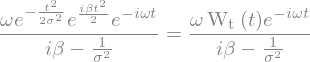

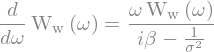

In [12]:
integrand = Wtexpr * sy.exp(-sy.I * omega * t)
# Ww = sy.integrate(integrand, t)
Ww = sy.Function('W_w')(omega)

integrand_diffw = integrand.diff(omega)
# Integration par parties
part1 = sy.exp(-sy.I * omega * t)
dpart1 = part1.diff(t)
dpart2 = sy.simplify(integrand_diffw / part1)
part2 = -sy.I * Wtexpr / (sy.I * beta - 1/sigma**2)
#assert((part2 - dpart2.integrate(t)).simplify() == 0)
assert((part2.diff(t) - dpart2.radsimp()).simplify() == 0)
print('Integrande après IPP:')
display(sy.Eq(-dpart1 * part2, (omega / (sy.I*beta - 1/sigma**2)) * (Wtfun * sy.exp(-sy.I * omega * t))))
display(sy.Eq(Ww.diff(omega), omega*Ww / (sy.I*beta - 1/sigma**2)))

ce qui se résoud facilement, avec une constante $C_1$ :

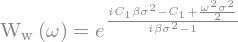

In [14]:
Ww_sol = sy.dsolve(sy.Eq(Ww.diff(omega), omega*Ww / (sy.I*beta - 1/sigma**2)), Ww).rhs
display(sy.Eq(Ww, Ww_sol))

## Détermination de la constante

Elle peut se faire en calculant $W_w(\omega=0)=\int_{-\infty}^{\infty} W_t(t) dt$

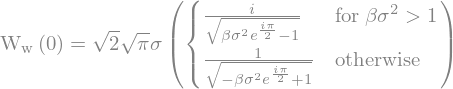

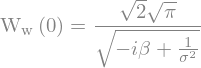

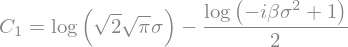

In [15]:
Ww_0 = sy.integrate(Wtexpr, (t, -sy.oo, sy.oo), conds='none')
display(sy.Eq(Ww.subs(omega, 0), Ww_0))
# Résultat exprimé sous forme conditionnelle, que l'on peut rassembler en une unique expression
Ww_0alt = sy.sqrt(2*sy.pi)/sy.sqrt(1/sigma**2 - sy.I*beta)
display(sy.Eq(Ww.subs(omega, 0), Ww_0alt))
C1var = [el for el in Ww_sol.free_symbols if str(el).startswith('C')][0]
C1expr = sy.solve(sy.Eq(Ww_sol.subs(omega, 0), Ww_0alt), C1var)[0]
C1expr = sy.logcombine(C1expr)
display(sy.Eq(C1var, C1expr))

## Expression finale

On substitue la dernière expression à la constante d'intégration:

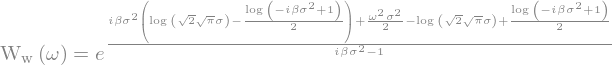

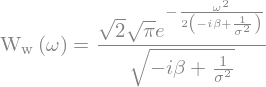

In [16]:
Ww_expr = sy.logcombine(Ww_sol.subs(C1var, C1expr))
display(sy.Eq(Ww, Ww_expr))
# On utilise une variable auxiliaire sans assertion (complexe/réelle/positive), ce qui aide à la simplification des logarithmes
# gamma = 1/sigma**2 - j*beta
tmpvar = sy.symbols('gamma')
tmpexpr = Ww_expr.subs(beta, sy.I * (tmpvar - 1/sigma**2)).simplify()
Ww_expr = tmpexpr.subs(tmpvar, 1/sigma**2 - sy.I * beta)
display(sy.Eq(Ww, Ww_expr))

# Calcul de la transformée de Gabor le long du chirp

Soit un signal $s(t)=S(t) e^{j\varphi(t)}$ où $\varphi$ correspondant au chirp seulement (modulation de fréquence), les modulations de phase et d'amplitude étant dans $S(t)$. On s'intéresse à l'estimation de sa «puissance» au voisinage de l'instant $\tau$ et de la pulsation $\alpha=\omega_i(\tau)=\varphi'(\tau)$, en tenant compte de la variation locale de cette pulsation. Pour cela, on calcule la transformée de Gabor pour la fenêtre gaussienne glissante en fréquence :

$$ L_g(\tau, \alpha) = \int_{\mathbb{R}} s(t) \left[W(t-\tau) e^{j\alpha(t-\tau)}\right]^* dt
    =\int_{\mathbb{R}} s(\tau+t') \left[W(t') e^{j\alpha t'}\right]^* dt'
\text{ avec }
W(t') = \exp{\left(-\frac{-t'^2}{2\sigma^2}\right)} \exp{\left(j\frac{1}{2}\beta t'^2\right)}
$$

En admettant que le signal et que l'approximation locale de l'enveloppe complexe $S(t=\tau + t')$ par son développement de Taylor à l'ordre $K$ :
$$ S(\tau+t') \simeq \sum_{k=0}^K \frac{S^{(k)}(\tau)}{k!} t'^k, $$
alors
$$\begin{split}
L_g(\tau, \alpha)
& = \int_{\mathbb{R}} S(\tau+t') \exp{\left(-\frac{-t'^2}{2\sigma^2}\right)} \exp{j\left(\varphi(\tau+t') - \alpha t' - \frac{1}{2}\beta t'^2\right)} dt'\\
& \simeq \int_{\mathbb{R}} \sum_{k=0}^K \frac{S^{(k)}(\tau)}{k!} t'^k \exp{\left(-\frac{-t'^2}{2\sigma^2}\right)} \exp{j\left(\varphi(\tau+t') - \alpha t' - \frac{1}{2}\beta t'^2\right)} dt'\\
& \simeq \sum_{k=0}^K \frac{S^{(k)}(\tau)}{k!} \int_{\mathbb{R}} t'^k \exp{\left(-\frac{-t'^2}{2\sigma^2}\right)} \exp{j\left(\varphi(\tau+t') - \alpha t' - \frac{1}{2}\beta t'^2\right)} dt'\\
L_g(\tau, \omega_i(\tau))& \simeq \sum_{k=0}^K \frac{S^{(k)}(\tau)}{k!} \int_{\mathbb{R}} t'^k \exp{\left(-\frac{-t'^2}{2\sigma^2}\right)} \exp{j\left(\varphi(\tau+t') - \varphi'(\tau)t' - \frac{1}{2}\varphi''(\tau) t'^2\right)} dt'
\text{ en choisissant $\beta=\varphi''(\tau)$}\\
& \simeq \sum_{k=0}^K \frac{S^{(k)}(\tau)}{k!} \exp{j\varphi(\tau)} \int_{\mathbb{R}} t'^k \exp{\left(-\frac{-t'^2}{2\sigma^2}\right)}  dt'
\text{ puisque, pour un chirp linéaire, $\varphi(\tau+t')= \varphi(\tau) + \varphi'(\tau) t' + \frac{1}{2}\varphi''(\tau)t'^2$}\\
& \simeq \sum_{k=0}^K \frac{\sigma^k S^{(k)}(\tau)}{k!} \exp{j\varphi(\tau)} %
\underbrace{\int_{\mathbb{R}} \left(\frac{t'}{\sigma}\right)^k \exp{\left(-\frac{-t'^2}{2\sigma^2}\right)}  dt'}_{=\sigma J_{k}}\\
& \simeq \sum_{k=0}^K \left(\frac{\sigma^{k+1} J_k}{k!} e^{j\varphi(\tau)}\right)  S^{(k)}(\tau) %
\end{split}.$$
Remarques:

  * Si le chirp n'est pas linéaire, il faut éventuellement corriger le terme de phase pour prendre en compte le résidu de $\varphi(\tau+t') - \varphi'(\tau)t' - \frac{1}{2}\varphi''(\tau) t'^2$ et utiliser le principe de la phase stationnaire.
  * Les coefficients $J_k=\int_\mathbb{R} u^k e^{-u^2/2} du$ sont facilement calculables (par ex par récurrence) :
    $$\forall k\ge 0, \ J_{2k+1} = 0\text{ et } J_{2k} = (2k-1)\times(2k-3)\times\ldots\times3\times1=\frac{(2k)!}{2^k k!} \sqrt{2\pi}.$$
    Ils sont nuls pour $k$ impair (par propriété de symétrie), ce qui signifie que seules les dérivées d'ordre pair influent sur la valeur de la transformée de Gabor.
  * Si on considère que le terme d'ordre 0 est dominant, on a :
    $$ L_g(\tau, \omega_i(\tau)) \simeq \sigma \sqrt{2\pi} e^{j\varphi(\tau)}  S(\tau)$$
    ce qui donne les facteurs à prendre en compte pour l'estimation de $S(\tau)$ à partir de $L_g(\tau, \omega_i(\tau))$.

En vue de séparer les contributions des termes d'ordres supérieurs, on peut généraliser la définition de cette transformée de Gabor en considérant des fenêtres d'analyse dérivées :
$$ L_g^p(\tau, \alpha)  = \int_{\mathbb{R}} s(\tau+t') \left[\left(\frac{t'}{\sigma}\right)^p W(t') e^{j\alpha t'}\right]^* dt' $$
soit $L_g^0(\tau, \alpha) = L_g(\tau, \alpha)$, et on montre facilement que
$$ L_g^p(\tau, \omega_i(\tau)) \simeq \sum_{k=0}^K \left(\frac{\sigma^{k+1} J_{k+p}}{k!} e^{j\varphi(\tau)}\right)  S^{(k)}(\tau) $$
On peut ainsi former le système linéaire :
$$
\begin{pmatrix}J_0 & J_2 & \ldots & J_{K}\\J_2 & J_4 && J_{K+2}\\ \vdots & & & \vdots\\ J_K & J_{K+2} & \ldots & J_{2K}\end{pmatrix}
\begin{pmatrix}
S(\tau)\\
\frac{\sigma^{2}}{2!} S''(\tau)\\
\vdots\\
\frac{\sigma^{K}}{K!} S^{(K)}(\tau)\end{pmatrix}
= \frac{e^{-j\varphi(\tau)}}{\sigma}\begin{pmatrix}L_g^0(\tau, \omega_i(\tau)) \\ L_g^2(\tau, \omega_i(\tau)) \\ \vdots \\ L_g^K(\tau, \omega_i(\tau))\end{pmatrix}
.$$

Pour chaque trame autour de $\tau$, il suffit de calculer $K/2$ transformées de Gabor (généralisées) formant le terme de droite, et de résoudre le système (où la matrice des $J_k$ est formée une seule fois et on peut même l'inverser une fois pour toutes), ce qui donne accès à une meilleure estimation de $S(\tau)$, mais aussi des dérivées paires.

D'autre part, le terme de correction de phase $\varphi(\tau)$ peut être obtenu par intégration de la pulsation instantannée (supposée connue pour un chirp imposé) :
$$ \varphi(\tau) = \int_0^\tau \omega_i(t) dt
 = \omega_i(0)\tau + \frac{\Delta\Omega}{2\Delta T} \tau^2 \text{ pour un chirp linéaire tel que }\omega_i(t) = \omega_i(0)+\Delta \omega\frac{t}{\Delta T}.$$

## Évaluations numériques

In [18]:
from importlib import reload
import frf
# reload(frf)

In [152]:
results = {}

array([[1.000000e+00, 1.000000e+00, 3.000000e+00, 1.500000e+01,
        1.050000e+02],
       [1.000000e+00, 3.000000e+00, 1.500000e+01, 1.050000e+02,
        9.450000e+02],
       [3.000000e+00, 1.500000e+01, 1.050000e+02, 9.450000e+02,
        1.039500e+04],
       [1.500000e+01, 1.050000e+02, 9.450000e+02, 1.039500e+04,
        1.351350e+05],
       [1.050000e+02, 9.450000e+02, 1.039500e+04, 1.351350e+05,
        2.027025e+06]])

array([1.000e+00, 2.000e+00, 2.400e+01, 7.200e+02, 4.032e+04])

<IPython.core.display.Javascript object>


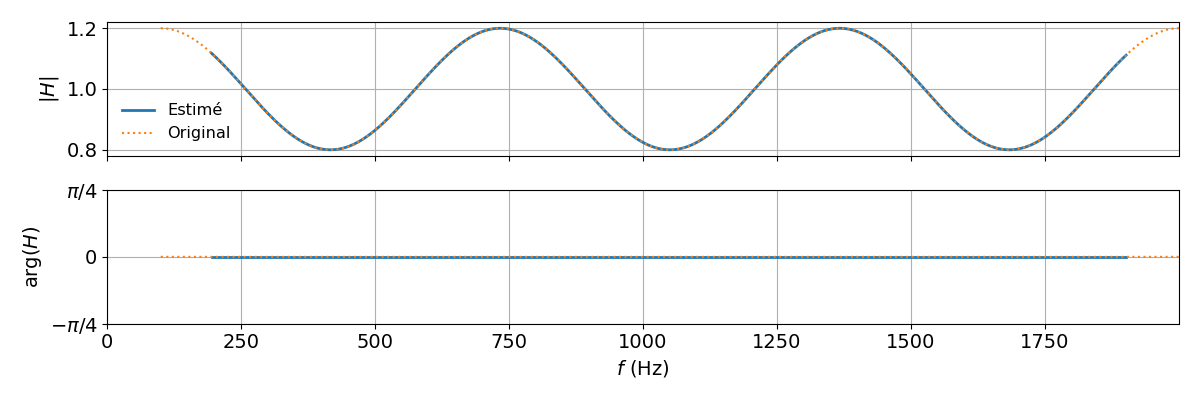

In [234]:
from scipy.linalg import hankel
import scipy.integrate as si
from math import factorial
import frf

fs, f0, f1, T0, T1 = 48000, 100., 2000., 0, 1.
duree_trame = 1e-1
nsig = int(fs * (T1 - T0))
# Longueur de trame impaire pour que la trame soit centrée en t=tau
ntrame = int(fs * duree_trame / 2) * 2 + 1  

# Chirp
S0num = 1.
w0, w1 = 2*np.pi * f0, 2*np.pi * f1
betanum = (w1 - w0) / (T1-T0)
tsig = np.arange(nsig) / float(fs)
wi_func = lambda t: w0 + betanum*t
phase_func = lambda t: w0 * t + .5 * betanum * t**2
# Modulation sinusoidale de l'amplitude (3 périodes) et linéaire pour la phase, en plus du chirp linéaire
modulation = lambda t: S0num * (1 + .2 * np.cos(6*np.pi*t/T1)) #* np.exp(-1.j * np.pi/2 * t / T1)
sig = modulation(tsig) * np.exp(1.j * phase_func(tsig))

# Noyau
sigmanum = duree_trame / np.sqrt(-8*np.log(1e-4))
tlocnum = (np.arange(ntrame) - ntrame//2) / float(fs)
enveloppe = np.exp(-.5 * (tlocnum/sigmanum)**2)
tlocnum2 = tlocnum**2 / sigmanum**2

factor = 1/ (sigmanum * np.sqrt(2*np.pi))


buffer = np.zeros(ntrame, dtype=complex)
toffset = 2e-3 #duree_trame/100
ltau = np.arange(T0 + duree_trame/2, T1 - duree_trame/2, toffset)
# conv = np.zeros(len(ltau), dtype=complex) + np.nan*(1. + 1.j)
estim = np.zeros(len(ltau), dtype=complex) + np.nan*(1. + 1.j)

iplot = 0 #len(ltau) // 3
if iplot:
    fig, (axtrame, axphase) = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
    
# Ordre maximal de dérivée de l'amplitude considérée
# S_0(t) = \sum_{k=0}^{K} \frac{S_0^(k)(\tau)}{k!} (t-\tau)^k
# K doit être pair
K = 8
if K > 0:
    assert(K%2 == 0)
    # Matrice permettant de calculer les dérivées paires S_0^(2k)(\tau)
    nrow = K//2 + 1
    tmp = [factorial(2*l) / (factorial(l) * 2**l) for l in range(K+1)]
    matA = sigmanum * np.sqrt(2*np.pi) * hankel(tmp[:nrow], tmp[nrow-1:])
    vecB = [factorial(k)/sigmanum**k for k in range(0, K+1, 2)]
    display(matA/ (sigmanum * np.sqrt(2*np.pi)) , vecB * sigmanum**np.arange(0, K+1, 2))


tempo = []
    
for itau, tau in enumerate(ltau):
    # Trame centrée en t=tau (approximativement)
    # Vecteur de taille ntrame (exactement)
    i0 = int((tau - duree_trame/2) * fs)
    idx = slice(i0, i0+ntrame)
    # Pulsation centrale
    Omega = wi_func(tau)
    phaseloc = Omega * tlocnum + 0.5 * betanum * tlocnum**2
    # Fenêtre d'analyse = gaussienne glissante + sinus alpha
    noyau = enveloppe * np.exp(1.j * phaseloc)
    # On prépare l'intégrande dans un buffer
    # alloué une fois pour toutes et écrasé à chaque itération
    buffer[:] = sig[idx]
    # Convolution discrète et correction avec la gaussienne g(t')
    buffer[:] *= np.conj(noyau)
    moments = [np.sum(buffer) * 1/fs,]
    
    
    if K == 0:
        # Hyp : amplitude localement constante
        absfactor = factor
        argfactor = Omega * tau - .5 * betanum * tau**2
        estim[itau] = moments[0] * np.exp(-1j * argfactor) * absfactor
    else:
        # On prend en compte les K premières dérivées (les K/2 dérivées paires)
        while len(moments) < K//2+1:
            # Convolution avec (t'/sigma)**k * g(t')
            buffer[:] *= tlocnum2
            tmp = np.sum(buffer) * 1/fs
            moments.append(tmp)

        # Séparation contribution des dérivées paires
        PhaseTau = Omega * tau - .5 * betanum * tau**2
        tmp = np.linalg.solve(matA, np.r_[moments] * np.exp(-1.j * PhaseTau))
        ampl_n_der = vecB * tmp
        tempo.append(ampl_n_der)
        estim[itau] = ampl_n_der[0]
    

    if iplot and (itau == iplot):
        axtrame.plot(tsig[idx], np.real(sig[idx]), label='Signal', c='b', lw=.2)
        axtrame.plot(tsig[idx], np.abs(modulation(tsig[idx])), label='Env. Signal', c='k', ls=':', lw=0.5)
        axtrame.plot(tau + tlocnum, np.real(noyau), label='Fenêtre', c='g', lw=.5, ls='-.')
        axtrame.plot(tau + tlocnum, np.real(buffer), label='Integrande - real', c='r', lw=.8)
        axtrame.plot(tau + tlocnum, np.imag(buffer), label='Integrande - imag', c='m', lw=.8)
        axtrame.plot(tau, np.abs(estim[itau]), label='Amplitude estimée', c='r', marker='o', ls='')
        axphase.plot(tsig[idx], wi_func(tsig[idx])/(2*np.pi), 'b', lw=.2)
        axphase.plot(tau + tlocnum, np.gradient(phaseloc) * fs/(2*np.pi), 'r', lw=.8, ls='-.')

if iplot:
    fig.suptitle('Trame %d ($\\tau=%.1e s$)' % (iplot, ltau[iplot]))
    axtrame.set_ylabel('Signaux')
    axtrame.legend(loc='lower right', ncol=1, frameon=True)
    axphase.set_ylabel('Fréquences (Hz)')

lfreq = wi_func(ltau) / (2*np.pi)
Bd = frf.BodeDiagram(lfreq, estim, label='Estimé', unwrap=True, lw=2)
Bd.add_frf(wi_func(tsig) / (2*np.pi), modulation(tsig), label='Original', ls=':')
if np.ptp(Bd.axs[1].get_ylim()) < np.pi/8:
    datamin, datamax = Bd.axs[1].get_ylim()
    Bd.axs[1].set_ylim(datamin-np.pi/4, datamax+np.pi/4)
Bd.fig.set_size_inches((12, 4))
Bd.fig.tight_layout()
Bd.fig.savefig('Gabor_Estimation.pdf')

results[K] = (ltau, lfreq, estim)

In [243]:
(17-4)/6.

<IPython.core.display.Javascript object>


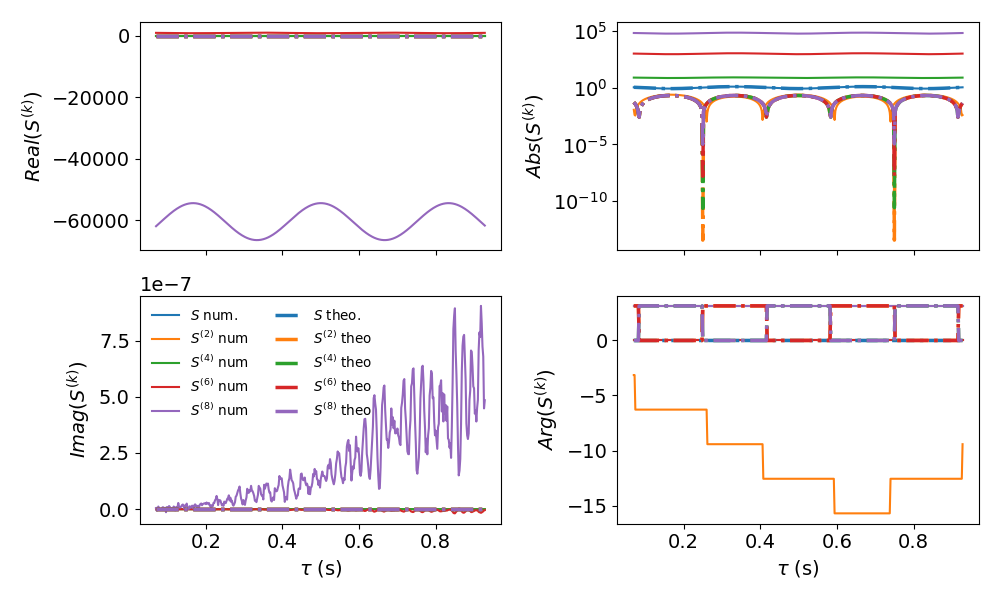

In [240]:
tempo = np.array(tempo)
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
def plot(z, **kw):
    sl = slice(10, -10)
    l, = axs[0, 0].plot(ltau[sl], np.real(z[sl]), **kw)
    axs[1, 0].plot(ltau[sl], np.imag(z)[sl], **kw)
    axs[0, 1].plot(ltau[sl], np.abs(z[sl]), **kw)
    axs[1, 1].plot(ltau[sl], np.unwrap(np.angle(z[sl])), **kw)
    return l


coef_normalisation = 6*np.pi/T1


# Résultats numériques
l = plot(tempo[:, 0], label='$S$ num.')
for K in range(1, tempo.shape[1]):
    plot(tempo[:, K]/coef_normalisation**(2*K), label='$S^{(%d)}$ num' % (2*K))
cols = [line.get_c() for line in axs[0, 0].get_lines()]

S0 = modulation(ltau)
#rappel: modulation = lambda t: S0num * .2 * np.cos(6*np.pi*t/T1) * np.exp(-1.j * np.pi/2 * t / T1)
plot(S0, ls='-.', lw=2.5, label="$S$ theo.", c=cols[0])
for K in range(1, tempo.shape[1]):
    S0 = np.gradient(np.gradient(S0, toffset), toffset)
    plot(S0/coef_normalisation**(2*K), ls='-.', lw=2.5, label='$S^{(%d)}$ theo' % (2*K), c=cols[K])
    
axs[1, 0].legend(ncol=2, fontsize='x-small')
axs[0, 0].set_ylabel('$Real(S^{(k)})$')
axs[1, 0].set_ylabel('$Imag(S^{(k)})$')
axs[0, 1].set_ylabel('$Abs(S^{(k)})$')
axs[1, 1].set_ylabel('$Arg(S^{(k)})$')
axs[0, 1].set_yscale('log')
for ax in axs[1]:
    ax.set_xlabel(r'$\tau$ (s)')
fig.tight_layout()

<IPython.core.display.Javascript object>


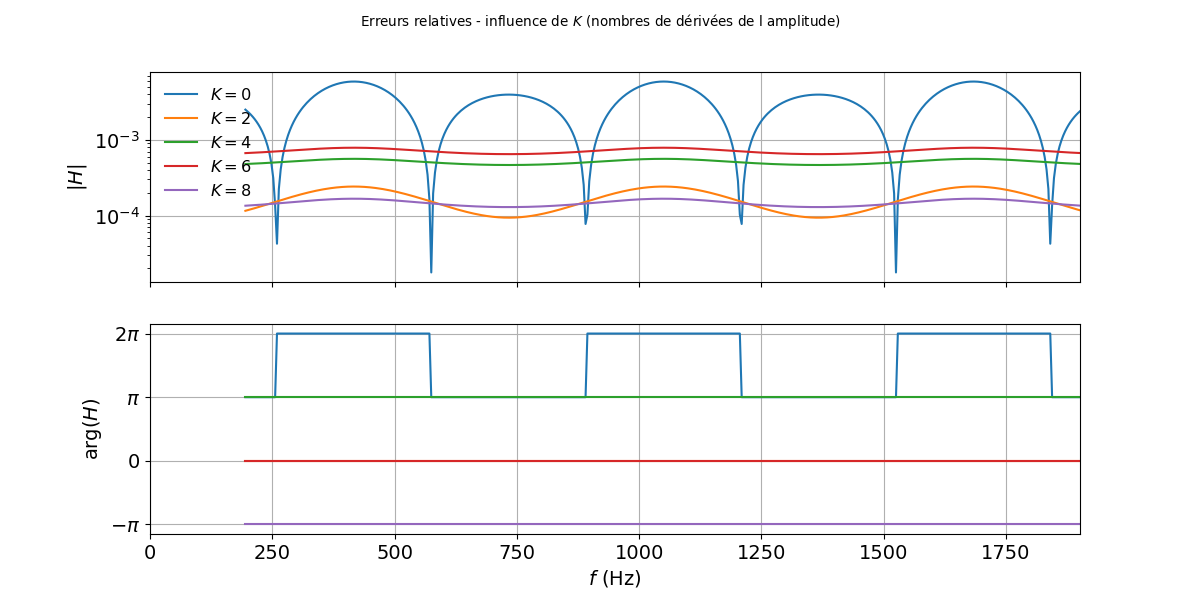

In [241]:
Bd = frf.BodeDiagram(None, None, label='erreur relative', unwrap=True)
for k, (ltau, lfreq, estim) in results.items():
    Bd.add_frf(lfreq, estim / modulation(ltau) - 1, label=r'$K=%d$' % k)
if np.ptp(Bd.axs[1].get_ylim()) < np.pi/8:
    datamin, datamax = Bd.axs[1].get_ylim()
    Bd.axs[1].set_ylim(datamin-np.pi/4, datamax+np.pi/4)
Bd.axs[0].set_yscale('log')
Bd.fig.set_size_inches((12, 6))
Bd.fig.suptitle('Erreurs relatives - influence de $K$ (nombres de dérivées de l amplitude)', fontsize='x-small')
# Bd.fig.tight_layout()
Bd.fig.savefig('Gabor_ModulationAM_erreurs.pdf')

|   K   | max(abs(e)) | avg(abs(e)) |
|-------|-------------|-------------|
| 0     | 6e-3        | 3e-3        |
| 2     | 2.0e-4      | 1.5e-4      |
| 4     | 5.5e-4      | 5.0e-4      |
| 6     | 7.8e-4      | 7.2e-4      |